In [1]:
import tensorflow as tf

Load & Preprocess Images

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = (96, 96)

train_ds = image_dataset_from_directory(
    "../cell_images_split/train",  
    validation_split=0.2,    
    subset="training",       
    seed=42,
    image_size=IMG_SIZE, 
    batch_size=32

)

val_ds = image_dataset_from_directory(
    "../cell_images_split/train",  
    validation_split=0.2,    
    subset="validation",     
    seed=42,
    image_size=IMG_SIZE, 
    batch_size=32
)

test_ds = image_dataset_from_directory(
    "../cell_images_split/test",    
    seed=42,
    image_size=IMG_SIZE, 
    batch_size=32
)


Found 22046 files belonging to 2 classes.
Using 17637 files for training.
Found 22046 files belonging to 2 classes.
Using 4409 files for validation.
Found 5512 files belonging to 2 classes.


Check Dimensions

In [5]:
for images, labels in train_ds.take(1):
  print(f"Images Shape: {images.shape}")
  print(f"Labels Shape: {labels.shape}")

Images Shape: (32, 96, 96, 3)
Labels Shape: (32,)


Check if we need normalization

In [6]:
for images, _ in train_ds.take(1):
  print(tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())

0.0 237.19661


2025-06-16 21:44:19.637960: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Apply normalization

In [7]:
def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

In [8]:
train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

Check normalized images

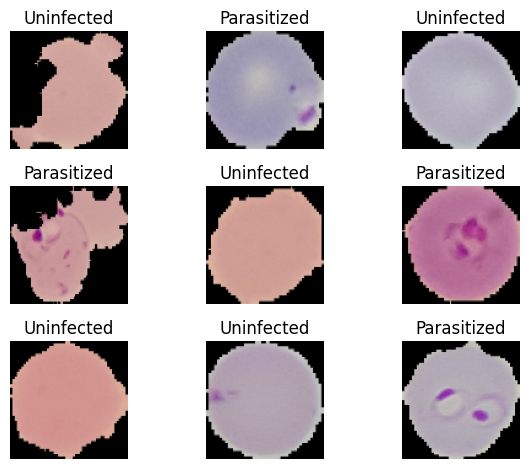

In [9]:
import matplotlib.pyplot as plt

class_names = ["Parasitized", "Uninfected"]
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

Build model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, Input

def build_model():
  model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
  
  return model


In [17]:
model = build_model()

Add Early Stopping

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

Train model

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.6510 - loss: 0.6593 - val_accuracy: 0.9186 - val_loss: 0.2476
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.9196 - loss: 0.2366 - val_accuracy: 0.9027 - val_loss: 0.2038
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - accuracy: 0.9233 - loss: 0.2125 - val_accuracy: 0.9324 - val_loss: 0.1825
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.9344 - loss: 0.1942 - val_accuracy: 0.9390 - val_loss: 0.1728
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.9346 - loss: 0.1777 - val_accuracy: 0.9365 - val_loss: 0.1812
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9397 - loss: 0.1699 - val_accuracy: 0.9351 - val_loss: 0.1941


Plot loss & accuracy over epochs

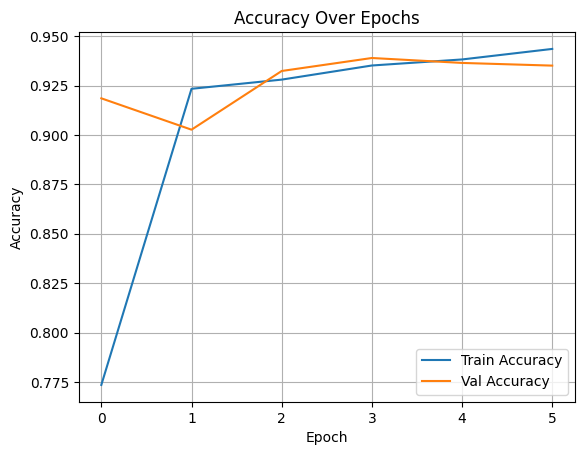

In [20]:
def plot_accuracy():
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Val Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

plot_accuracy()

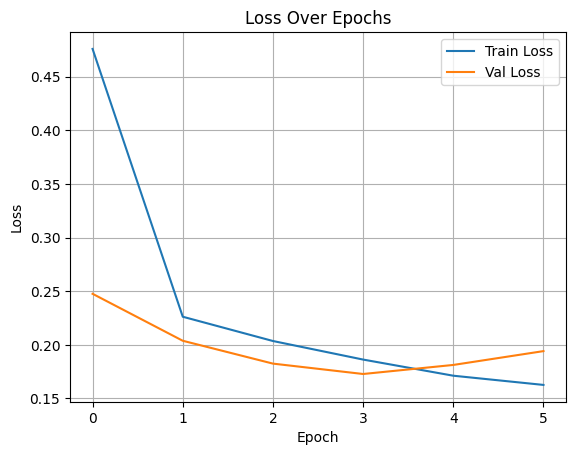

In [21]:
def plot_loss():
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

plot_loss()

Evaluate the model on the test set

In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"🧪 Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9376 - loss: 0.1754
🧪 Test accuracy: 0.9361, Test loss: 0.1746


Classfication report

In [23]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
  preds = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(preds)

y_pred = np.array(y_pred) > 0.5
y_true = np.array(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [25]:
from sklearn.metrics import classification_report

print("Classification Report: ")
print(classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))

Classification Report: 
              precision    recall  f1-score   support

 Parasitized       0.93      0.94      0.94      2756
  Uninfected       0.94      0.93      0.94      2756

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



Plot confusion matrix

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

def plot_cm(cm, class_1, class_2):
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=[class_1, class_2],
              yticklabels=[class_1, class_2])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()


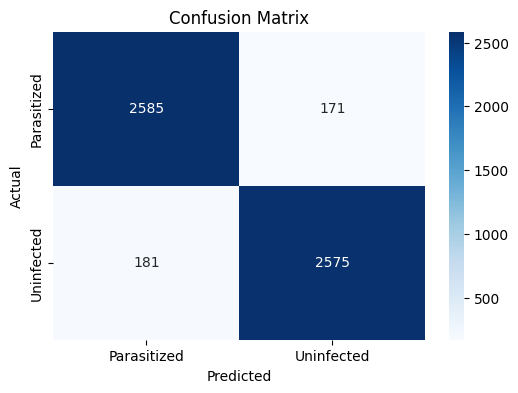

In [29]:
plot_cm(cm, "Parasitized", "Uninfected")